In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [ ]:
df = pd.read_csv('data.csv')

Combine Date and Time columns into a single datetime column

In [ ]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing 'kWh' suffix

In [ ]:
df['Energy'] = df['Energy'].str.replace('kWh', '').astype(float)

In [ ]:
df.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df = df.resample('30min').last()

In [ ]:
df.head()

,Date,Time,Energy
DateTime,,,
2024-08-15 00:00:00,15/08/2024,12:25AM,0.0
2024-08-15 00:30:00,15/08/2024,12:55AM,0.0
2024-08-15 01:00:00,15/08/2024,1:25AM,0.0
2024-08-15 01:30:00,15/08/2024,1:55AM,0.0
2024-08-15 02:00:00,15/08/2024,2:25AM,0.0


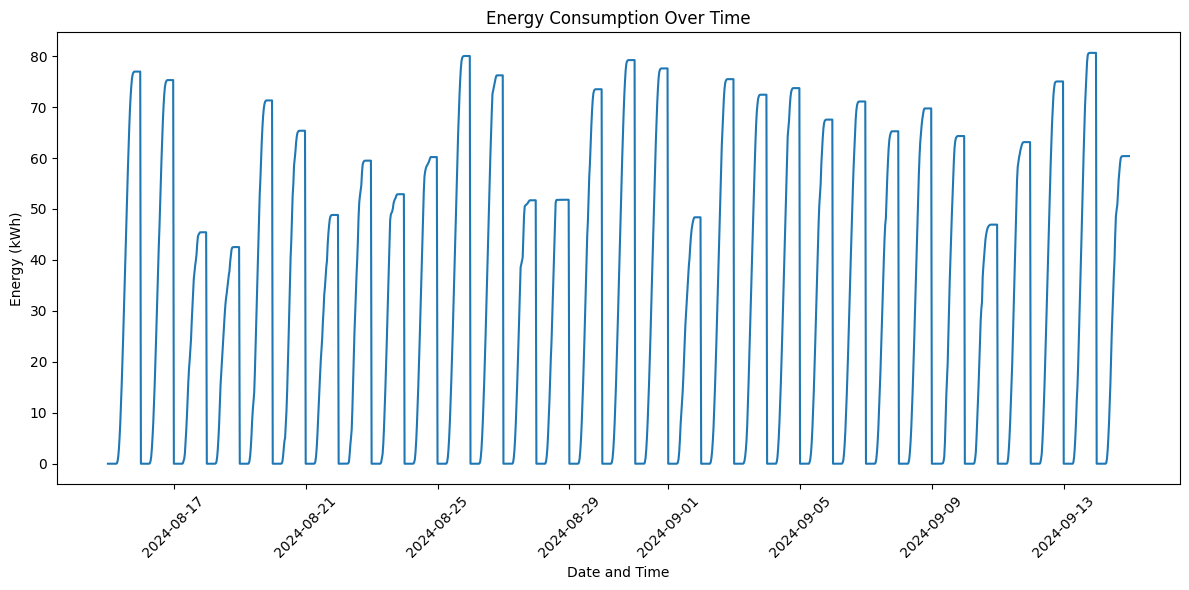

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.470848e+01
p-value                        2.872302e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.464000e+03
Critical Value (1%)           -3.434825e+00
Critical Value (5%)           -2.863516e+00
Critical Value (10%)          -2.567822e+00
dtype: float64


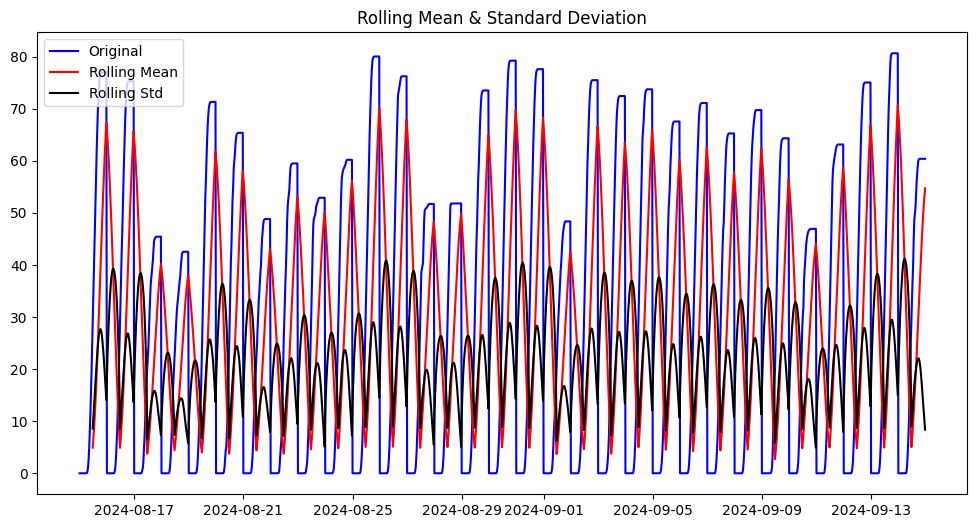

In [ ]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Plot rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    plt.figure(figsize=(12,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Check stationarity
check_stationarity(df['Energy'])


The test statistic (-14.71) is much lower (more negative) than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value (2.87e-27) is significantly smaller than 0.05, meaning we reject the null hypothesis of non-stationarity. Therefore, the data are considered stationary.

Split the data into training and testing sets (80% train, 20% test)

In [ ]:
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

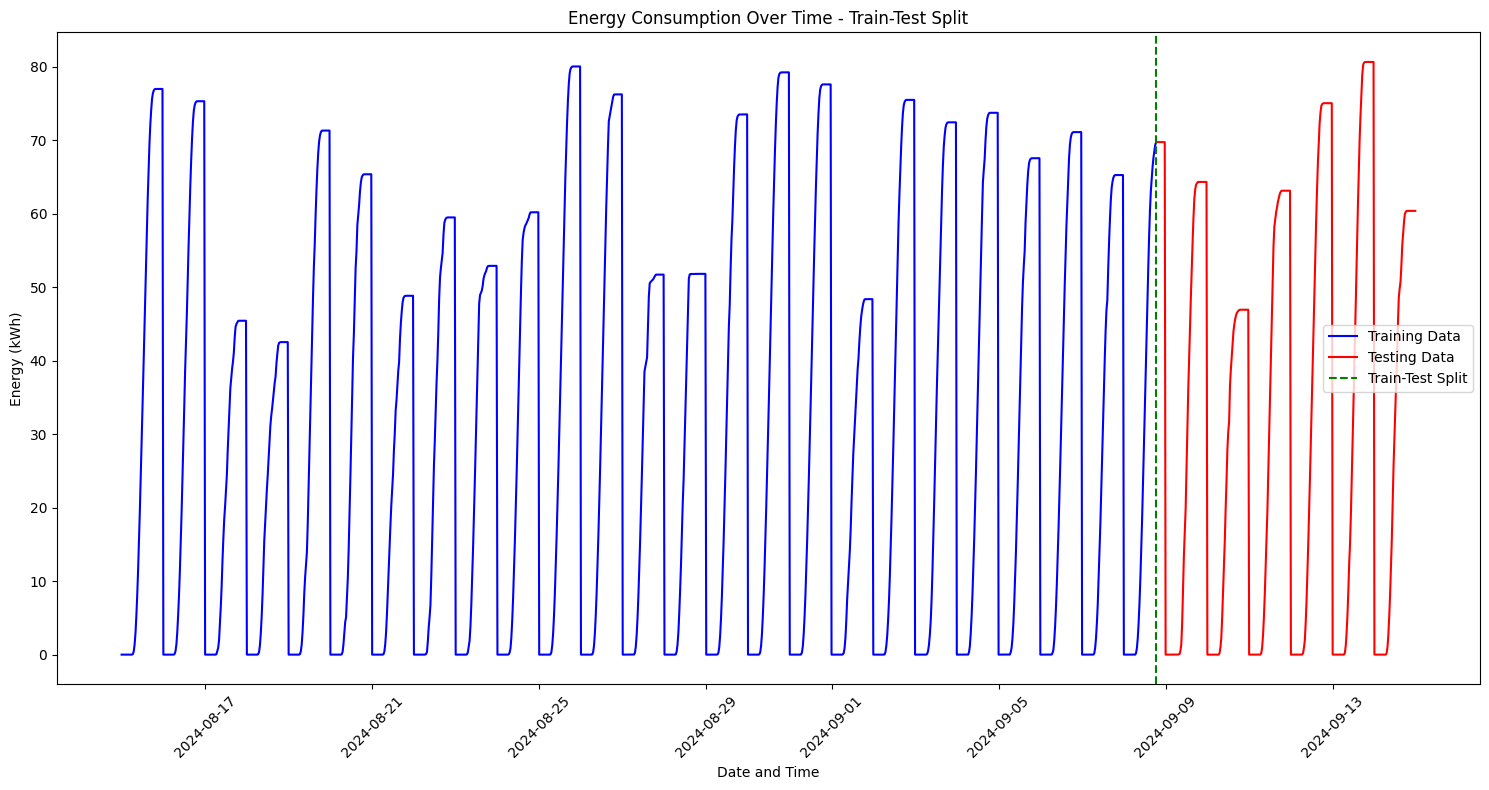

In [ ]:
plt.figure(figsize=(15, 8))

# Plot training data
plt.plot(train_data.index, train_data['Energy'], label='Training Data', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data['Energy'], label='Testing Data', color='red')


# Add a vertical line to show the split point
split_date = train_data.index[-1]
plt.axvline(x=split_date, color='green', linestyle='--', label='Train-Test Split')

plt.title('Energy Consumption Over Time - Train-Test Split')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
train_data = train_data[['Energy']].astype(float)
test_data = test_data[['Energy']].astype(float)

In [ ]:
auto_model = auto_arima(train_data,
                        seasonal=True,
                        m=48,
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        start_P=0, start_Q=0,
                        max_P=1, max_Q=1,
                        d=1, D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        random_state=20,
                        n_fits=50)

print(f"Best SARIMA parameters: {auto_model.order}")
print(f"Best seasonal order: {auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[48]             : AIC=5200.226, Time=2.86 sec
 ARIMA(1,1,0)(1,1,0)[48]             : AIC=5149.252, Time=8.26 sec
 ARIMA(0,1,1)(0,1,1)[48]             : AIC=inf, Time=26.89 sec
 ARIMA(1,1,0)(0,1,0)[48]             : AIC=5190.279, Time=0.79 sec
 ARIMA(1,1,0)(1,1,1)[48]             : AIC=inf, Time=98.70 sec
 ARIMA(1,1,0)(0,1,1)[48]             : AIC=inf, Time=29.96 sec
 ARIMA(0,1,0)(1,1,0)[48]             : AIC=5158.297, Time=4.15 sec
 ARIMA(2,1,0)(1,1,0)[48]             : AIC=5147.456, Time=8.79 sec
 ARIMA(2,1,0)(0,1,0)[48]             : AIC=5188.801, Time=1.42 sec
 ARIMA(2,1,0)(1,1,1)[48]             : AIC=inf, Time=127.41 sec


In [ ]:
model = SARIMAX(train_data,
                order=(2,1,0),
                seasonal_order=(1,1,0,48),
                enforce_stationarity=True,
                enforce_invertibility=True)

results = model.fit()

In [ ]:
forecast = results.forecast(steps=len(test_data))

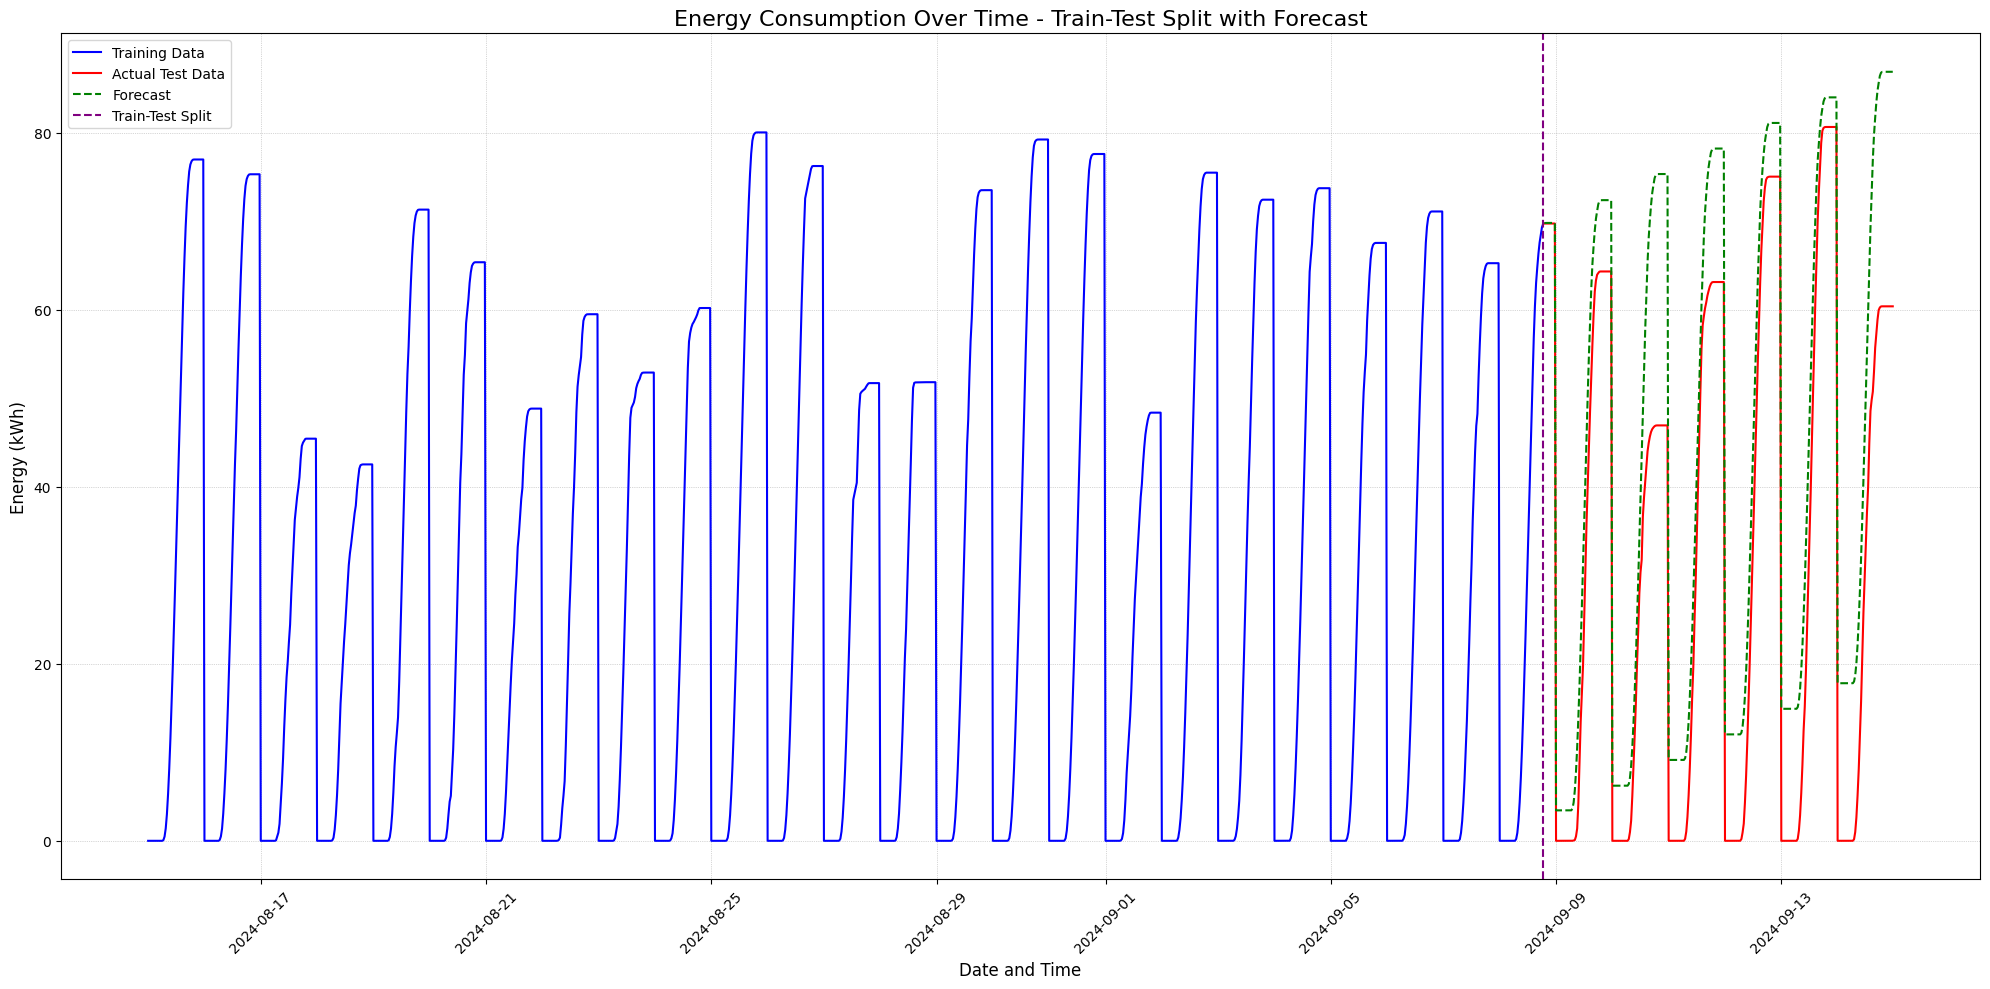

In [ ]:
plt.figure(figsize=(20, 10))

# Plot training data
plt.plot(train_data.index, train_data['Energy'], label='Training Data', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data['Energy'], label='Actual Test Data', color='red')

# Plot forecast
plt.plot(test_data.index, forecast, label='Forecast', color='green', linestyle='--')

# Add a vertical line to show the split point
split_date = train_data.index[-1]
plt.axvline(x=split_date, color='purple', linestyle='--', label='Train-Test Split')

plt.title('Energy Consumption Over Time - Train-Test Split with Forecast', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()

plt.show()

In [ ]:
mae = mean_absolute_error(test_data['Energy'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Energy'], forecast))

print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"Root Mean Square Error: {rmse:.2f} kWh")

Mean Absolute Error: 11.73 kWh
Root Mean Square Error: 13.79 kWh
